In [9]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.0 MB/s eta 0:00:0000:01


### Importing the Necessary Libraries

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import utils, nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms
import snntorch as snn
from snntorch import surrogate
import snntorch.functional as SF

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device in use: {device}")

Device in use: cuda


### Data Loading and Preprocessing

In [12]:
X_train = np.load("/kaggle/input/kth-compressed/X_train_kth.npy")
X_val = np.load("/kaggle/input/kth-compressed/X_val_kth.npy")
X_test = np.load("/kaggle/input/kth-compressed/X_test_kth.npy")

y_train = np.load("/kaggle/input/kth-compressed/y_train_kth.npy")
y_val = np.load("/kaggle/input/kth-compressed/y_val_kth.npy")
y_test = np.load("/kaggle/input/kth-compressed/y_test_kth.npy")

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1560, 32, 64, 64) (390, 32, 64, 64) (345, 32, 64, 64)
(1560,) (390,) (345,)


In [13]:
print(X_train.min(), X_train.max())
print(X_val.min(), X_val.max())
print(X_test.min(), X_test.max())

0.00073529413 1.0
0.0009803922 1.0
0.0037990196 1.0


In [14]:
CATEGORIES = {
    "boxing": 0,
    "handclapping": 1,
    "handwaving": 2,
    "jogging": 3,
    "running": 4,
    "walking": 5
}

reverse_category_map = {val : key for key, val in CATEGORIES.items()}
print(reverse_category_map)

{0: 'boxing', 1: 'handclapping', 2: 'handwaving', 3: 'jogging', 4: 'running', 5: 'walking'}


### Data Visualization

In [7]:
def plot_sample(frame = 12, idx = None):
    if idx == None:
        idx = np.random.randint(X_train.shape[0])
    img_, label_ =  X_train[idx][frame], reverse_category_map[y_train[idx]]
    plt.axis('off')
    plt.title(f"Label: {label_} | Frame: {frame}")
    plt.imshow(img_, cmap = "gray")

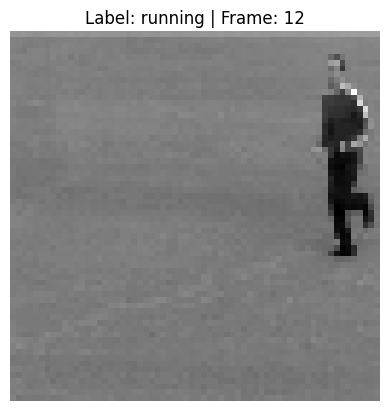

In [51]:
plot_sample()

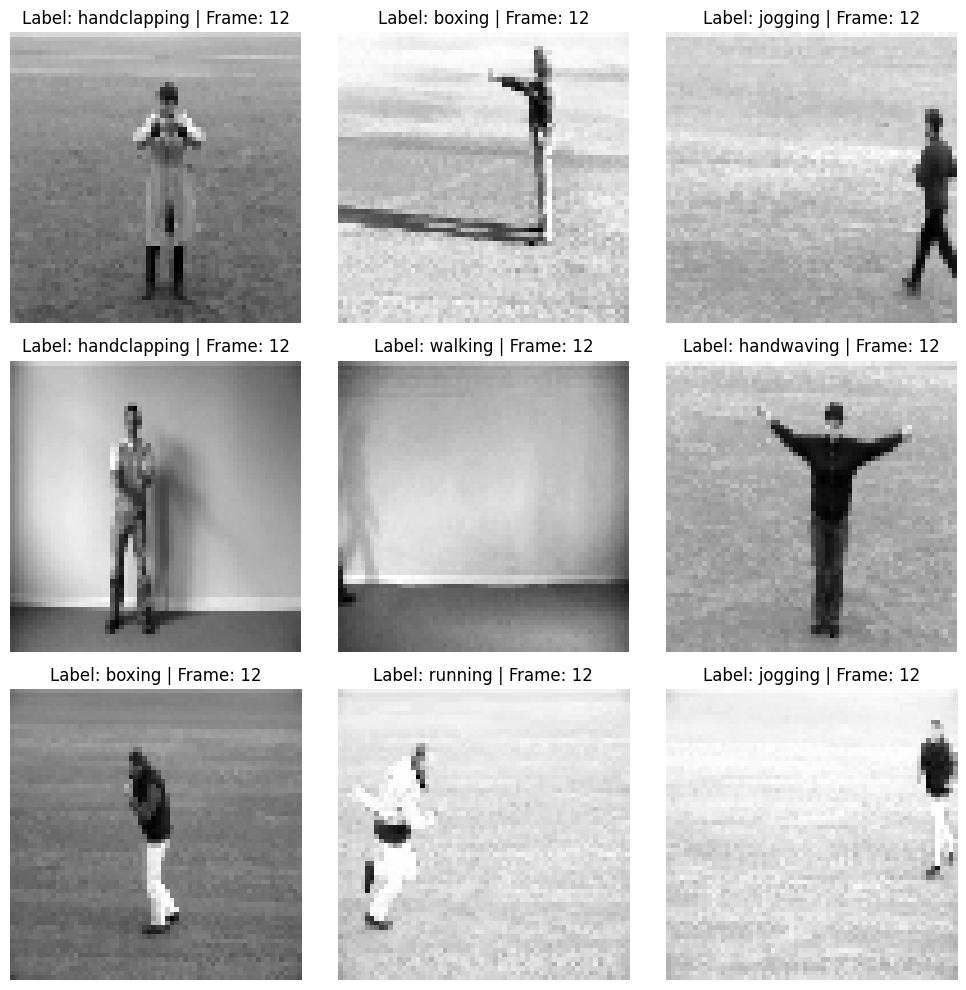

In [52]:
plt.figure(figsize = (10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plot_sample()
plt.tight_layout()
plt.show()

In [15]:
X_train = X_train.reshape(X_train.shape[0], 1, 32, 64, 64)
X_val = X_val.reshape(X_val.shape[0], 1, 32, 64, 64)
X_test = X_test.reshape(X_test.shape[0], 1, 32, 64, 64)

print(X_train.shape, X_val.shape, X_test.shape)

(1560, 1, 32, 64, 64) (390, 1, 32, 64, 64) (345, 1, 32, 64, 64)


In [16]:
X_train_ = torch.tensor(X_train).float()
X_val_ = torch.tensor(X_val).float()
X_test_ = torch.tensor(X_test).float()

y_train_ = torch.tensor(y_train).long() 
y_val_ = torch.tensor(y_val).long()
y_test_ = torch.tensor(y_test).long()

print(X_train_.shape, X_val_.shape, X_test_.shape)

torch.Size([1560, 1, 32, 64, 64]) torch.Size([390, 1, 32, 64, 64]) torch.Size([345, 1, 32, 64, 64])


In [17]:
train_dataset = TensorDataset(X_train_, y_train_)
val_dataset = TensorDataset(X_val_, y_val_)
test_dataset = TensorDataset(X_test_, y_test_)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [18]:
*_, last_set = iter(train_loader)
data, targets = last_set
data = data.to(device)
targets = targets.to(device)
print(data.shape, targets.shape)  # 1560 % batch_size

*_, last_set = iter(val_loader)
data, targets = last_set
data = data.to(device)
targets = targets.to(device)
print(data.shape, targets.shape)  # 390 % batch_size

*_, last_set = iter(test_loader)
data, targets = last_set
data = data.to(device)
targets = targets.to(device)
print(data.shape, targets.shape)  # 345 % batch_size

torch.Size([24, 1, 32, 64, 64]) torch.Size([24])
torch.Size([6, 1, 32, 64, 64]) torch.Size([6])
torch.Size([25, 1, 32, 64, 64]) torch.Size([25])


### Defining the Convolutional SNN Architecture

In [19]:
beta = 0.9  # Decay
spike_gradient = surrogate.fast_sigmoid(slope = 25)
num_steps = 6
epoch_num = 10

In [24]:
class SNN_model(nn.Module):
    def __init__(self, num_steps, input_channel = 1):
        super(SNN_model, self).__init__()
        self.num_steps = num_steps
        self.conv1 = nn.Conv3d(input_channel, 64, 5, 1, 2)
        self.lif1 = snn.Leaky(beta = beta, spike_grad = spike_gradient)
        self.pool = nn.AvgPool3d(2)
        self.conv2 = nn.Conv3d(64, 128, 5, 1, 2)
        self.lif2 = snn.Leaky(beta = beta, spike_grad = spike_gradient)
        self.fc1 = nn.Linear(262144, 6)
        self.lif3 = snn.Leaky(beta = beta, spike_grad = spike_gradient)

    def forward(self, x):
        batch_size_curr = x.shape[0]
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spk3_rec = []
        mem3_rec = []

        for step in range(self.num_steps):
            cur1 = self.pool(self.conv1(x))
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.pool(self.conv2(spk1))
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc1(spk2.view(batch_size_curr, -1))
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec), torch.stack(mem3_rec)

In [25]:
snn_model = SNN_model(num_steps).to(device)
print(snn_model)
optimizer_snn = torch.optim.Adam(snn_model.parameters(), lr = 1e-2, betas = (0.9, 0.999))
loss_snn = nn.CrossEntropyLoss()

SNN_model(
  (conv1): Conv3d(1, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (lif1): Leaky()
  (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv3d(64, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (lif2): Leaky()
  (fc1): Linear(in_features=262144, out_features=6, bias=True)
  (lif3): Leaky()
)


In [26]:
def train_snn(network, train_dl, num_epochs, num_steps):
    loss_hist = []
    acc_hist = []
    for epoch in range(num_epochs):
        for i, (data, targets) in enumerate(iter(train_dl)):
            data = data.to(device)
            targets = targets.to(device)

            network.train()
            spk_rec, mem_rec = network(data)

            loss_val = torch.zeros((1), dtype = torch.float, device = device)
            for step in range(num_steps):
                loss_val += loss_snn(mem_rec[step], targets)

            optimizer_snn.zero_grad()
            loss_val.backward()
            optimizer_snn.step()

        loss_hist.append(loss_val.item())
        print(f"Epoch: {epoch + 1}\nTrain Loss: {loss_val.item():.2f}")
        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")
    return loss_hist, acc_hist

In [27]:
history = train_snn(snn_model, train_loader, epoch_num, num_steps)

Epoch: 1
Train Loss: 1005.78
Accuracy: 16.67%

Epoch: 2
Train Loss: 413.31
Accuracy: 20.83%

Epoch: 3
Train Loss: 603.75
Accuracy: 4.17%

Epoch: 4
Train Loss: 858.21
Accuracy: 41.67%

Epoch: 5
Train Loss: 213.50
Accuracy: 25.00%

Epoch: 6
Train Loss: 457.07
Accuracy: 25.00%

Epoch: 7
Train Loss: 435.35
Accuracy: 12.50%

Epoch: 8
Train Loss: 434.83
Accuracy: 16.67%

Epoch: 9
Train Loss: 338.48
Accuracy: 4.17%

Epoch: 10
Train Loss: 230.76
Accuracy: 8.33%



In [20]:
def test_snn(network, test_dl, num_steps):
    size, correct = 0, 0
    loss_val = 0
    with torch.no_grad():
        network.eval()
        for data, targets in test_dl:
            data = data.to(device)
            targets = targets.to(device)

            test_spk, test_mem = network(data)

            _, predicted = test_spk.sum(dim = 0).max(1)
            size += targets.size(0)
            correct += (predicted == targets).sum().item()
            loss_val += loss_snn(test_mem[num_steps-1], targets)

    test_loss = loss_val / size
    print(f"Total correctly classified test set images: {correct} / {size}")
    print(f"Test set accuracy: {100 * correct / size:.2f}%, avg loss: {test_loss:>8f}")

In [28]:
def train_snn_with_early_stopping(network, train_dl, test_dl, num_epochs, num_steps, patience = 5):
    loss_hist = []
    acc_hist = []
    best_acc = 0
    no_improvement_count = 0

    for epoch in range(num_epochs):
        for i, (data, targets) in enumerate(iter(train_dl)):
            data = data.to(device)
            targets = targets.to(device)

            network.train()
            spk_rec, mem_rec = network(data)

            loss_val = torch.zeros((1), dtype=torch.float, device=device)
            for step in range(num_steps):
                loss_val += loss_snn(mem_rec[step], targets)

            optimizer_snn.zero_grad()
            loss_val.backward()
            optimizer_snn.step()

            loss_hist.append(loss_val.item())

        print(f"Epoch: {epoch + 1} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        size, correct = 0, 0
        loss_val = 0
        with torch.no_grad():
            network.eval()
            for data, targets in test_dl:
                data = data.to(device)
                targets = targets.to(device)

                test_spk, test_mem = network(data)

                _, predicted = test_spk.sum(dim = 0).max(1)
                size += targets.size(0)
                correct += (predicted == targets).sum().item()
                loss_val += loss_snn(test_mem[num_steps - 1], targets)

        test_acc = 100 * correct / size
        print(f"Validation set accuracy: {test_acc:.2f}%")

        if test_acc > best_acc:
            best_acc = test_acc
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            
        if no_improvement_count >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break
    print(f"Best validation set accuracy: {best_acc:.2f}%")
    return loss_hist, acc_hist

In [29]:
# Training the model with Early Stopping

train_snn_with_early_stopping(snn_model, train_loader, val_loader, epoch_num, num_steps)

Epoch: 1 
Train Loss: 409.06
Accuracy: 29.17%

Validation set accuracy: 16.15%
Epoch: 2 
Train Loss: 206.56
Accuracy: 8.33%

Validation set accuracy: 16.15%
Epoch: 3 
Train Loss: 207.48
Accuracy: 25.00%

Validation set accuracy: 16.15%
Epoch: 4 
Train Loss: 341.76
Accuracy: 4.17%

Validation set accuracy: 16.15%
Epoch: 5 
Train Loss: 278.43
Accuracy: 16.67%

Validation set accuracy: 16.15%
Epoch: 6 
Train Loss: 291.80
Accuracy: 12.50%

Validation set accuracy: 16.15%
Early stopping triggered after 6 epochs.
Best validation set accuracy: 16.15%


([365.7636413574219,
  227.8570556640625,
  296.63531494140625,
  232.97662353515625,
  383.40093994140625,
  373.2850036621094,
  309.06982421875,
  371.4491271972656,
  350.1929931640625,
  403.9840087890625,
  351.53289794921875,
  255.46890258789062,
  293.61004638671875,
  256.5823974609375,
  234.3154754638672,
  336.178466796875,
  353.85748291015625,
  395.9925842285156,
  370.9097900390625,
  195.52696228027344,
  119.80670166015625,
  164.70635986328125,
  290.66705322265625,
  359.51678466796875,
  284.91387939453125,
  232.87156677246094,
  298.0329284667969,
  313.88311767578125,
  190.21226501464844,
  160.93992614746094,
  286.83721923828125,
  232.86517333984375,
  213.01898193359375,
  183.86007690429688,
  179.5653839111328,
  206.33116149902344,
  236.06256103515625,
  266.10980224609375,
  331.4073486328125,
  407.0026550292969,
  224.9215087890625,
  445.53826904296875,
  241.96884155273438,
  171.71859741210938,
  342.4515380859375,
  321.19830322265625,
  232.383

In [ ]:
def evaluate_model(network, test_dl, num_steps):
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        network.eval()
        for data, targets in test_dl:
            data = data.to(device)
            targets = targets.to(device)

            test_spk, _ = network(data)

            _, predicted = test_spk.sum(dim=0).max(1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Test Precision: {precision * 100:.2f}%")
    print(f"Test Recall: {recall * 100:.2f}%")
    print(f"Test F1-Score: {f1 * 100:.2f}%")
    
    return [all_targets, all_predictions]

In [ ]:
test_snn(snn_model, test_loader, num_steps)

In [ ]:
y_test_true, y_test_pred = evaluate_model(snn_model, test_loader, num_steps)